In [53]:
!pip install catboost
import requests
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# General libraries
import numpy as np
import pandas as pd
import os
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words


#machine learning Algorithms For Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

100%|██████████| 211k/211k [00:00<00:00, 824kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [11]:
data_path = os.path.join(path, 'spam.csv')  # Correct path to the CSV file
data = pd.read_csv(data_path, encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
data .info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [13]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
data.head()


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
le = LabelEncoder()
data['target'] = le.fit_transform(data['target'])
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
data.isnull().sum()

,0
target,0
text,0


In [18]:
data.duplicated().sum()

403

In [19]:
data.drop_duplicates(keep='first', inplace=True)

In [24]:

# Number of Characters
data['num_chars'] = data['text'].apply(len)
# Number of Words
data['num_words'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))
# Number of Sentences
data['num_sentences'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
data.head()

,target,text,num_chars,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [27]:
# Describe function for ham messages
data[data['target'] == 0][['num_chars', 'num_words', 'num_sentences' ]].describe()


,num_chars,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [28]:
# Describe function for spam messages
data[data['target'] == 1][['num_chars', 'num_words', 'num_sentences' ]].describe()

,num_chars,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


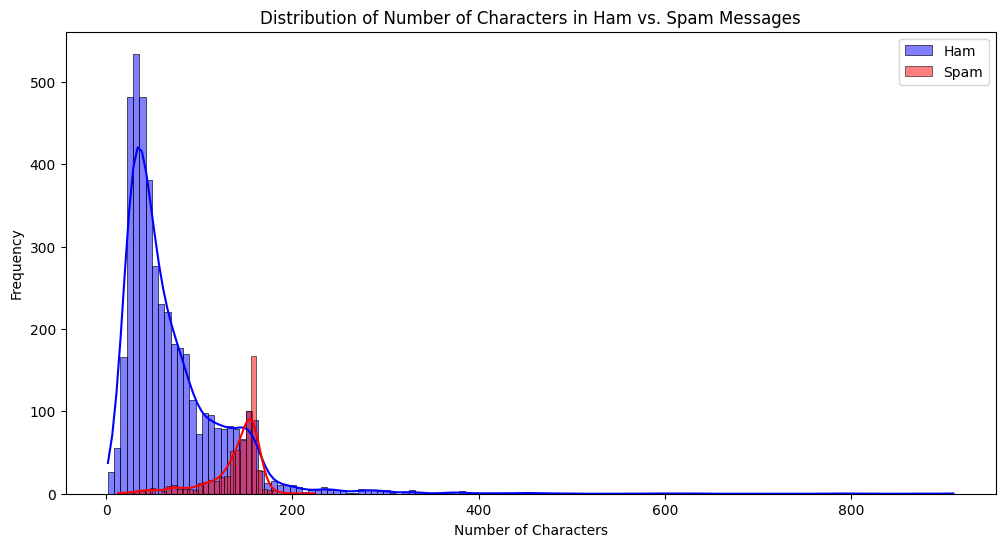

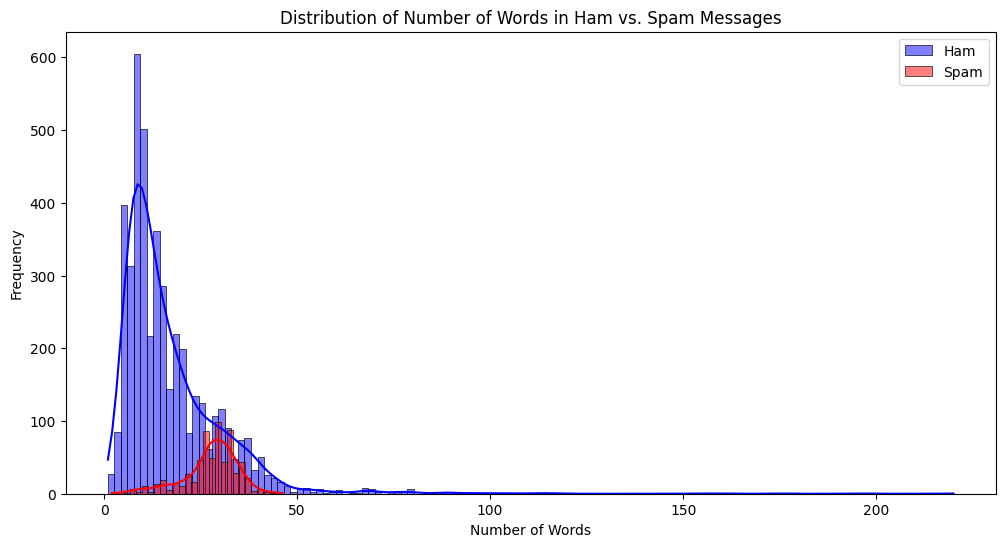

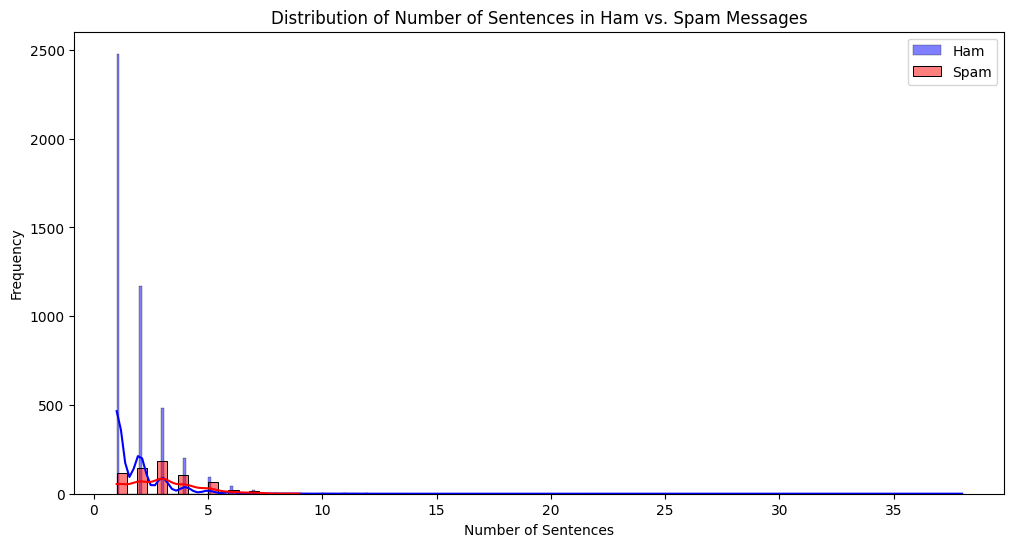

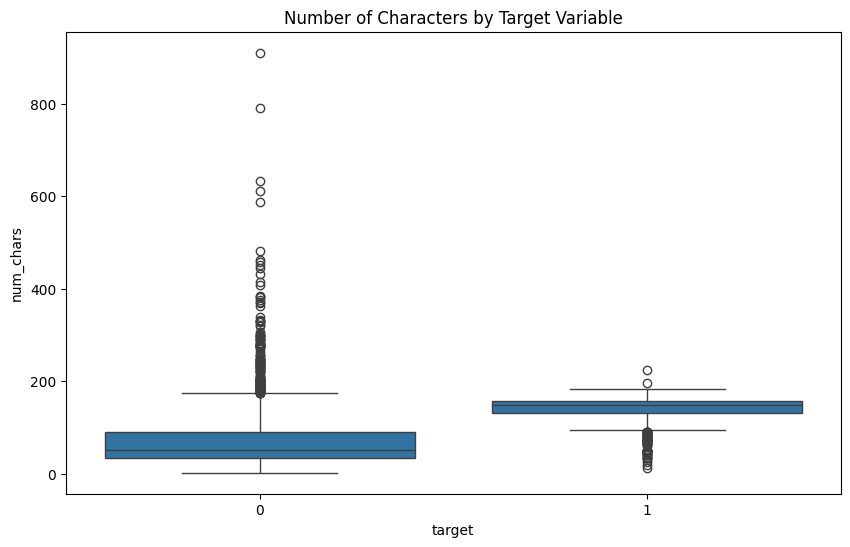

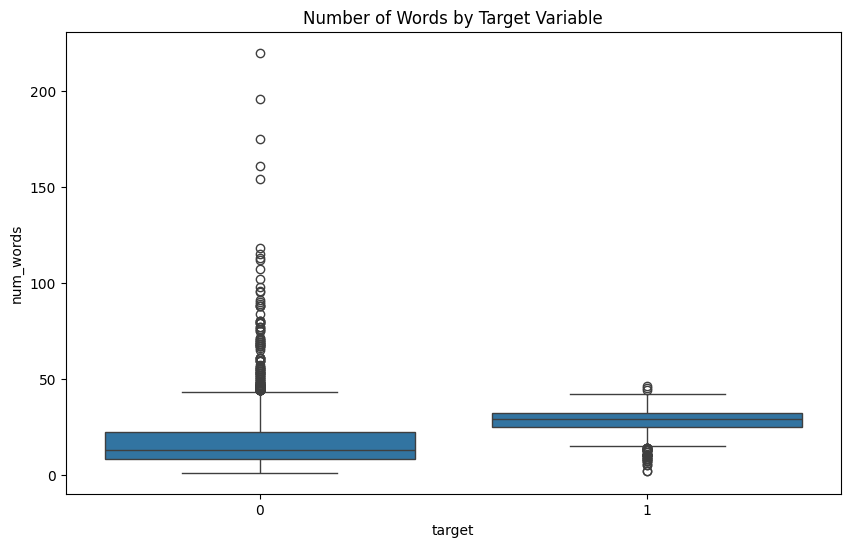

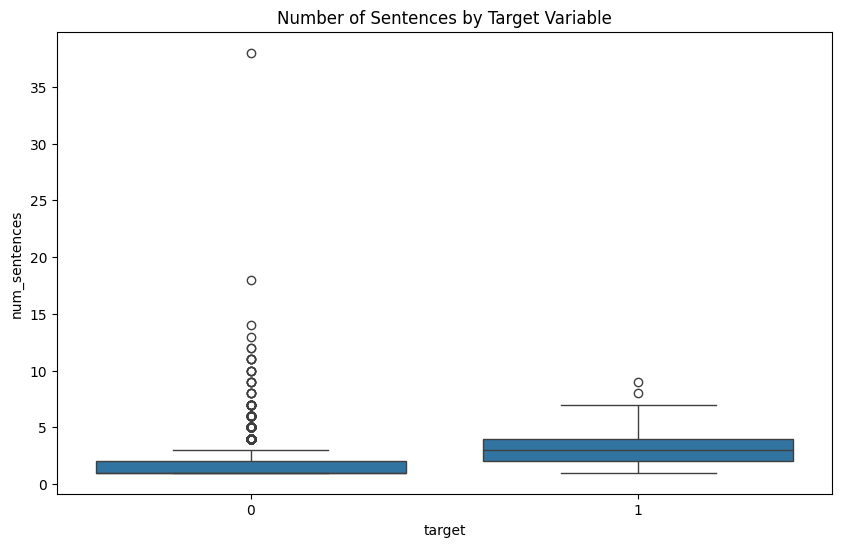

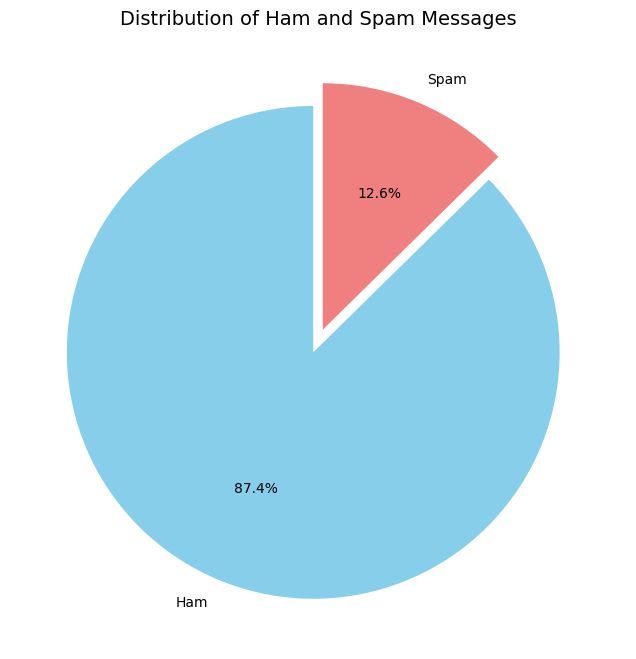

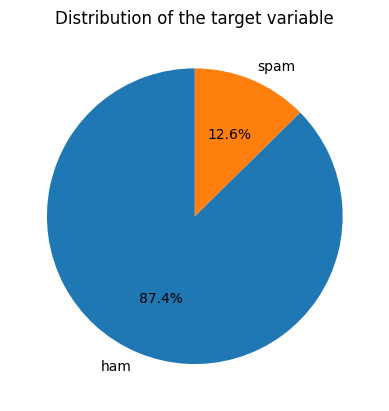

In [30]:


# Visualizations with improved clarity and insights

plt.figure(figsize=(12, 6))
sns.histplot(data[data['target'] == 0]['num_chars'], color='blue', label='Ham', kde=True, alpha=0.5)
sns.histplot(data[data['target'] == 1]['num_chars'], color='red', label='Spam', kde=True, alpha=0.5)
plt.title('Distribution of Number of Characters in Ham vs. Spam Messages')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['target'] == 0]['num_words'], color='blue', label='Ham', kde=True, alpha=0.5)
sns.histplot(data[data['target'] == 1]['num_words'], color='red', label='Spam', kde=True, alpha=0.5)
plt.title('Distribution of Number of Words in Ham vs. Spam Messages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['target'] == 0]['num_sentences'], color='blue', label='Ham', kde=True, alpha=0.5)
sns.histplot(data[data['target'] == 1]['num_sentences'], color='red', label='Spam', kde=True, alpha=0.5)
plt.title('Distribution of Number of Sentences in Ham vs. Spam Messages')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Boxplots for a more compact comparison

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='num_chars', data=data)
plt.title('Number of Characters by Target Variable')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='num_words', data=data)
plt.title('Number of Words by Target Variable')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='num_sentences', data=data)
plt.title('Number of Sentences by Target Variable')
plt.show()


# Enhanced Pie Chart for Target Variable Distribution

plt.figure(figsize=(8, 8))
data['target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Ham', 'Spam'], explode=[0.05,0.05], colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Ham and Spam Messages', fontsize=14)
plt.ylabel('') # Remove y-axis label
plt.show()

plt.pie(data['target'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of the target variable')
plt.show()

<Axes: >

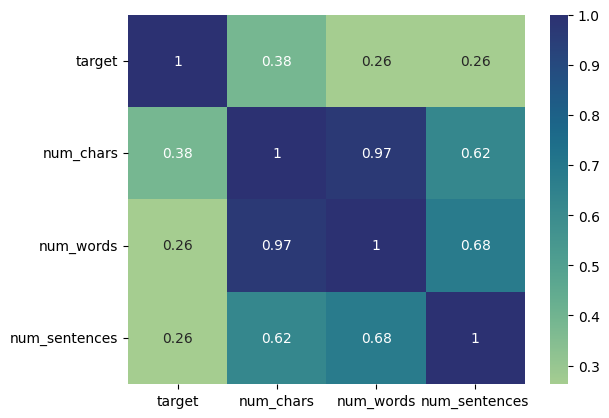

In [32]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data.corr()
sns.heatmap(numeric_data.corr(), annot=True, cmap='crest')


In [34]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [35]:
data['transformed_text'] = data['text'].apply(transform_text)
data.head()

,target,text,num_chars,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


Text(0.5, 1.0, 'Most common words in ham messages')

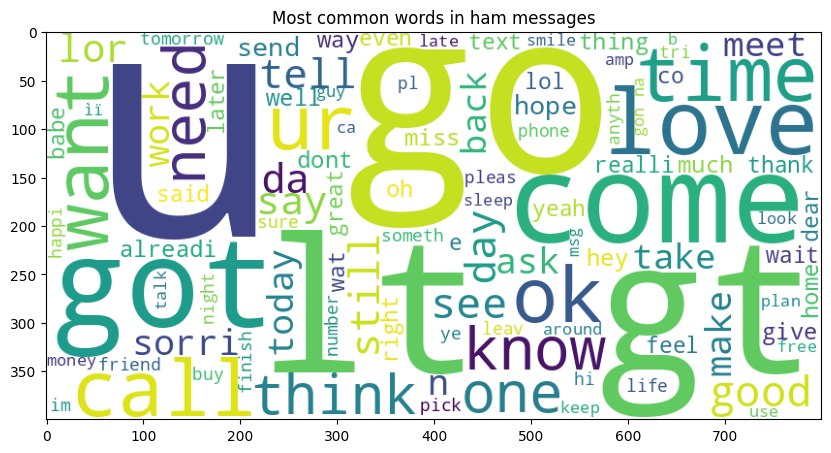

In [38]:

wc = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(data['transformed_text']))


ham_wc = wc.generate(' '.join(data[data['target'] == 0]['transformed_text']))
plt.figure(figsize=(10, 6))
plt.imshow(ham_wc)
plt.title('Most common words in ham messages')

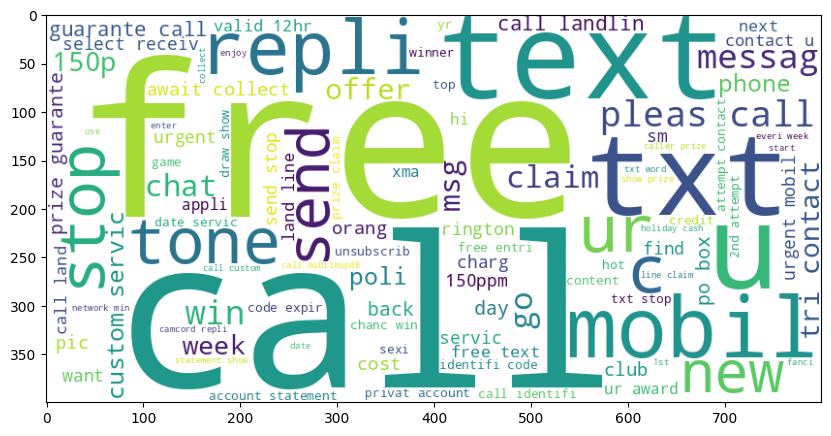

In [39]:
spam_wc = wc.generate(' '.join(data[data['target'] == 1]['transformed_text']))
plt.figure(figsize=(10, 6))
plt.imshow(spam_wc)

In [44]:
ham_corpus = []
for message in data[data['target'] == 0]['transformed_text']:
    for word in message.split():
        ham_corpus.append(word)
len(ham_corpus)

35404

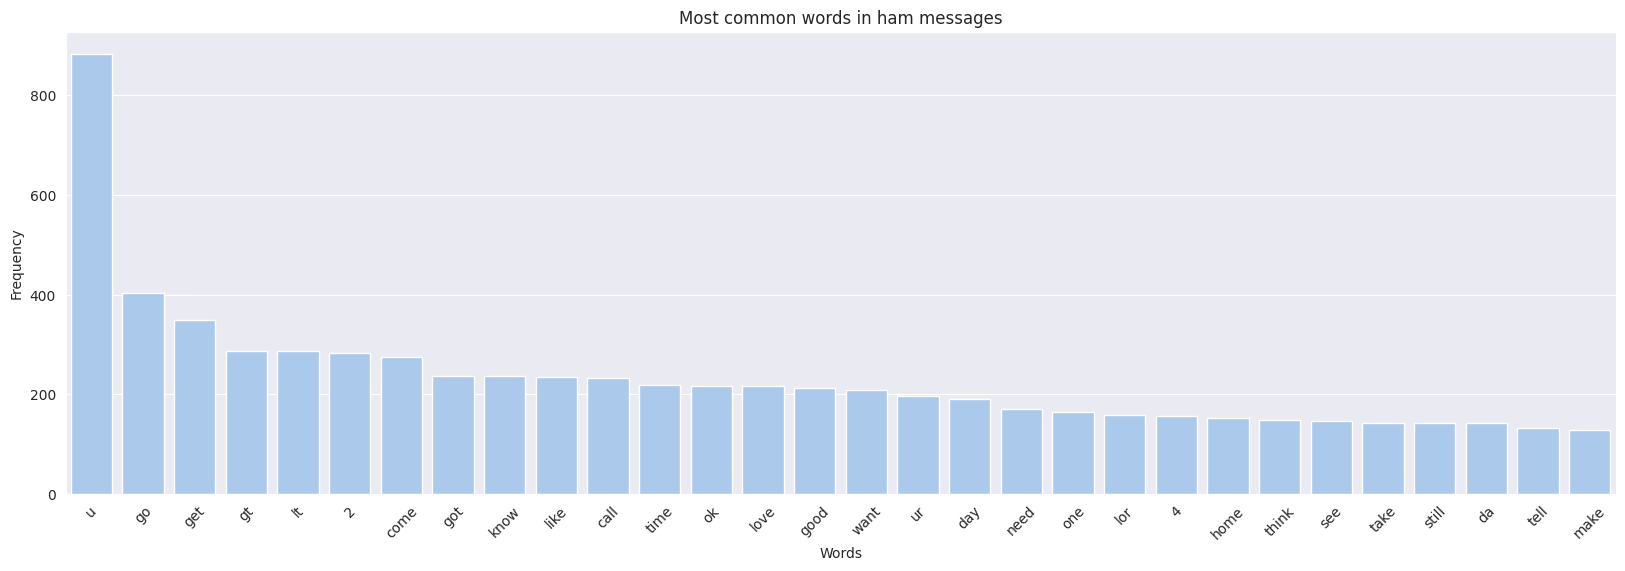

In [45]:
sns.set_palette('pastel')
sns.set_style('darkgrid')
counter = Counter(ham_corpus)
plt.figure(figsize=(20, 6))
sns.barplot(x=[item[0] for item in counter.most_common(30)], y=[item[1] for item in counter.most_common(30)])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most common words in ham messages')
plt.xticks(rotation=45)
plt.show()

In [42]:
spam_corpus = []
for message in data[data['target'] == 1]['transformed_text']:
    for word in message.split():
        spam_corpus.append(word)
len(spam_corpus)


9939

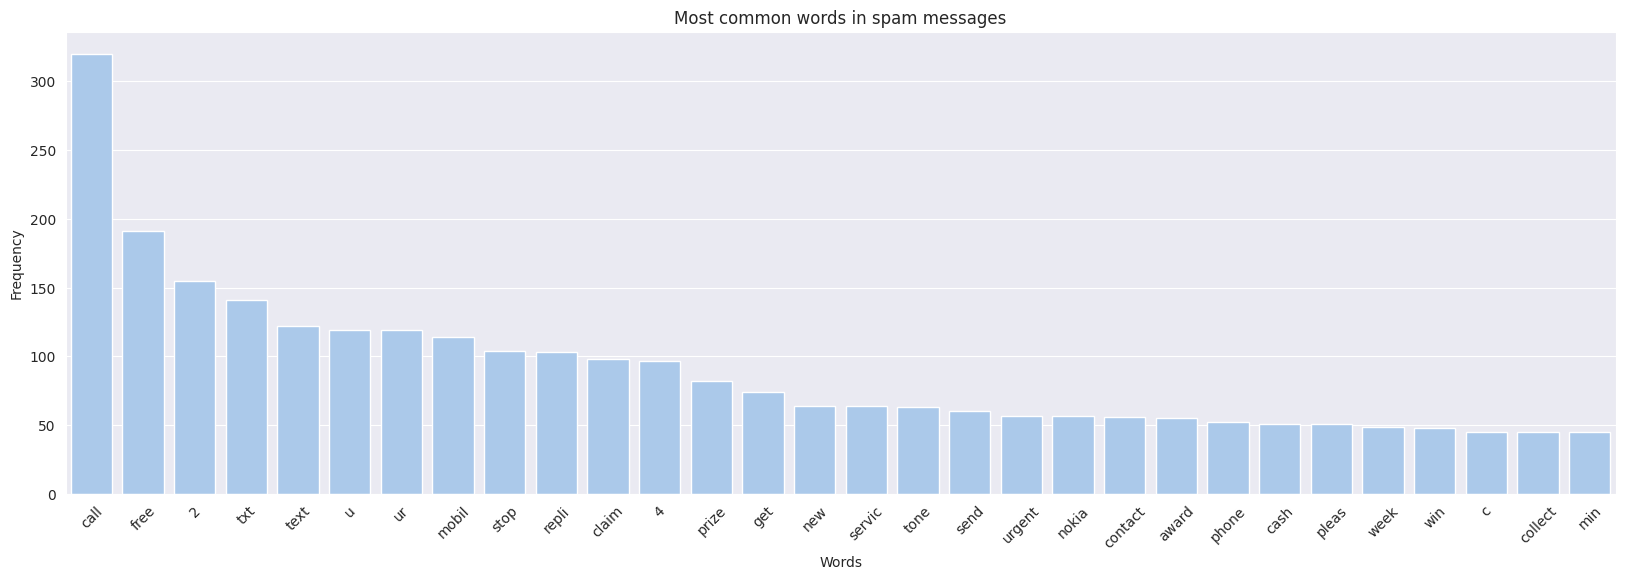

In [43]:

counter = Counter(spam_corpus)
sns.set_palette('pastel')
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(x=[item[0] for item in counter.most_common(30)], y=[item[1] for item in counter.most_common(30)])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most common words in spam messages')
plt.xticks(rotation=45)
plt.show()

In [48]:

cv = CountVectorizer()
data.head()

,target,text,num_chars,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [49]:
X = cv.fit_transform(data['transformed_text'], data['num_chars']).toarray()
y = data['target'].values
X.shape, y.shape

((5169, 6708), (5169,))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [64]:
# Dictionary of classification algorithms
algorithms = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Gaussian Naive Baye": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),  # Suppress LightGBM logs
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)

}


In [61]:


def evaluate_vectorizer(X_train, X_test, y_train, y_test, classifiers, models_dir):
    # Create directory to save models
    os.makedirs(models_dir, exist_ok=True)

    # Initialize a figure for confusion matrices
    num_classifiers = len(classifiers)
    num_rows = int(np.ceil(num_classifiers / 3))  # Adjust columns as needed
    num_cols = 3  # You can adjust this for a different layout

    # Initialize a figure with enough subplots
    plt.figure(figsize=(20, num_rows * 5))  # Adjust figure height dynamically


    # Dictionary to store results for all models
    results = {}

    # Train and evaluate each classifier
    for i, (name, model) in enumerate(classifiers.items()):
        print(f"Training {name}...")

        # Fit the model
        model.fit(X_train, y_train)

        # Save the trained model
        model_filename = os.path.join(models_dir, f"{name}.joblib")
        joblib.dump(model, model_filename)
        print(f"Saved {name} model to {model_filename}")

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store metrics in the results dictionary
        results[name] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_matrix(y_test, y_pred)
        }

        # Print metrics
        print(f"{name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("-" * 40)

        # Plot confusion matrix in a subplot
        cm = results[name]["confusion_matrix"]
        plt.subplot(num_rows, num_cols, i + 1)  # Use calculated rows and columns
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"{name}\nConfusion Matrix")
        plt.colorbar()

        # Get the number of unique classes in the target variable
        num_classes = len(np.unique(y_test))

        tick_marks = np.arange(num_classes)  # Use num_classes instead of hardcoding 7
        plt.xticks(tick_marks, np.unique(y_test), rotation=45)  # Use unique class labels
        plt.yticks(tick_marks, np.unique(y_test))  # Use unique class labels

        # Labeling the matrix - adjust loop ranges
        for j in range(cm.shape[0]):  # Iterate over actual classes (rows)
            for k in range(cm.shape[1]):  # Iterate over predicted classes (columns)
                plt.text(k, j, format(cm[j, k], 'd'), ha="center", va="center", color="red")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to hold the performance scores
    performance_df = pd.DataFrame({
        'Model': list(classifiers.keys()),
        'Accuracy': [results[name]['accuracy'] for name in classifiers],
        'Precision': [results[name]['precision'] for name in classifiers],
        'Recall': [results[name]['recall'] for name in classifiers],
        'F1 Score': [results[name]['f1_score'] for name in classifiers]
    }).sort_values(by='Precision', ascending=False)

    return performance_df

Training Logistic Regression...
Saved Logistic Regression model to cv_saved_models/Logistic Regression.joblib
Logistic Regression Metrics:
Accuracy: 0.9787
Precision: 0.9790
Recall: 0.9787
F1 Score: 0.9780
----------------------------------------
Training Decision Tree...
Saved Decision Tree model to cv_saved_models/Decision Tree.joblib
Decision Tree Metrics:
Accuracy: 0.9584
Precision: 0.9574
Recall: 0.9584
F1 Score: 0.9566
----------------------------------------
Training Random Forest...
Saved Random Forest model to cv_saved_models/Random Forest.joblib
Random Forest Metrics:
Accuracy: 0.9729
Precision: 0.9737
Recall: 0.9729
F1 Score: 0.9716
----------------------------------------
Training SVC...
Saved SVC model to cv_saved_models/SVC.joblib
SVC Metrics:
Accuracy: 0.9710
Precision: 0.9716
Recall: 0.9710
F1 Score: 0.9696
----------------------------------------
Training KNN...
Saved KNN model to cv_saved_models/KNN.joblib
KNN Metrics:
Accuracy: 0.9062
Precision: 0.9154
Recall: 0.9062

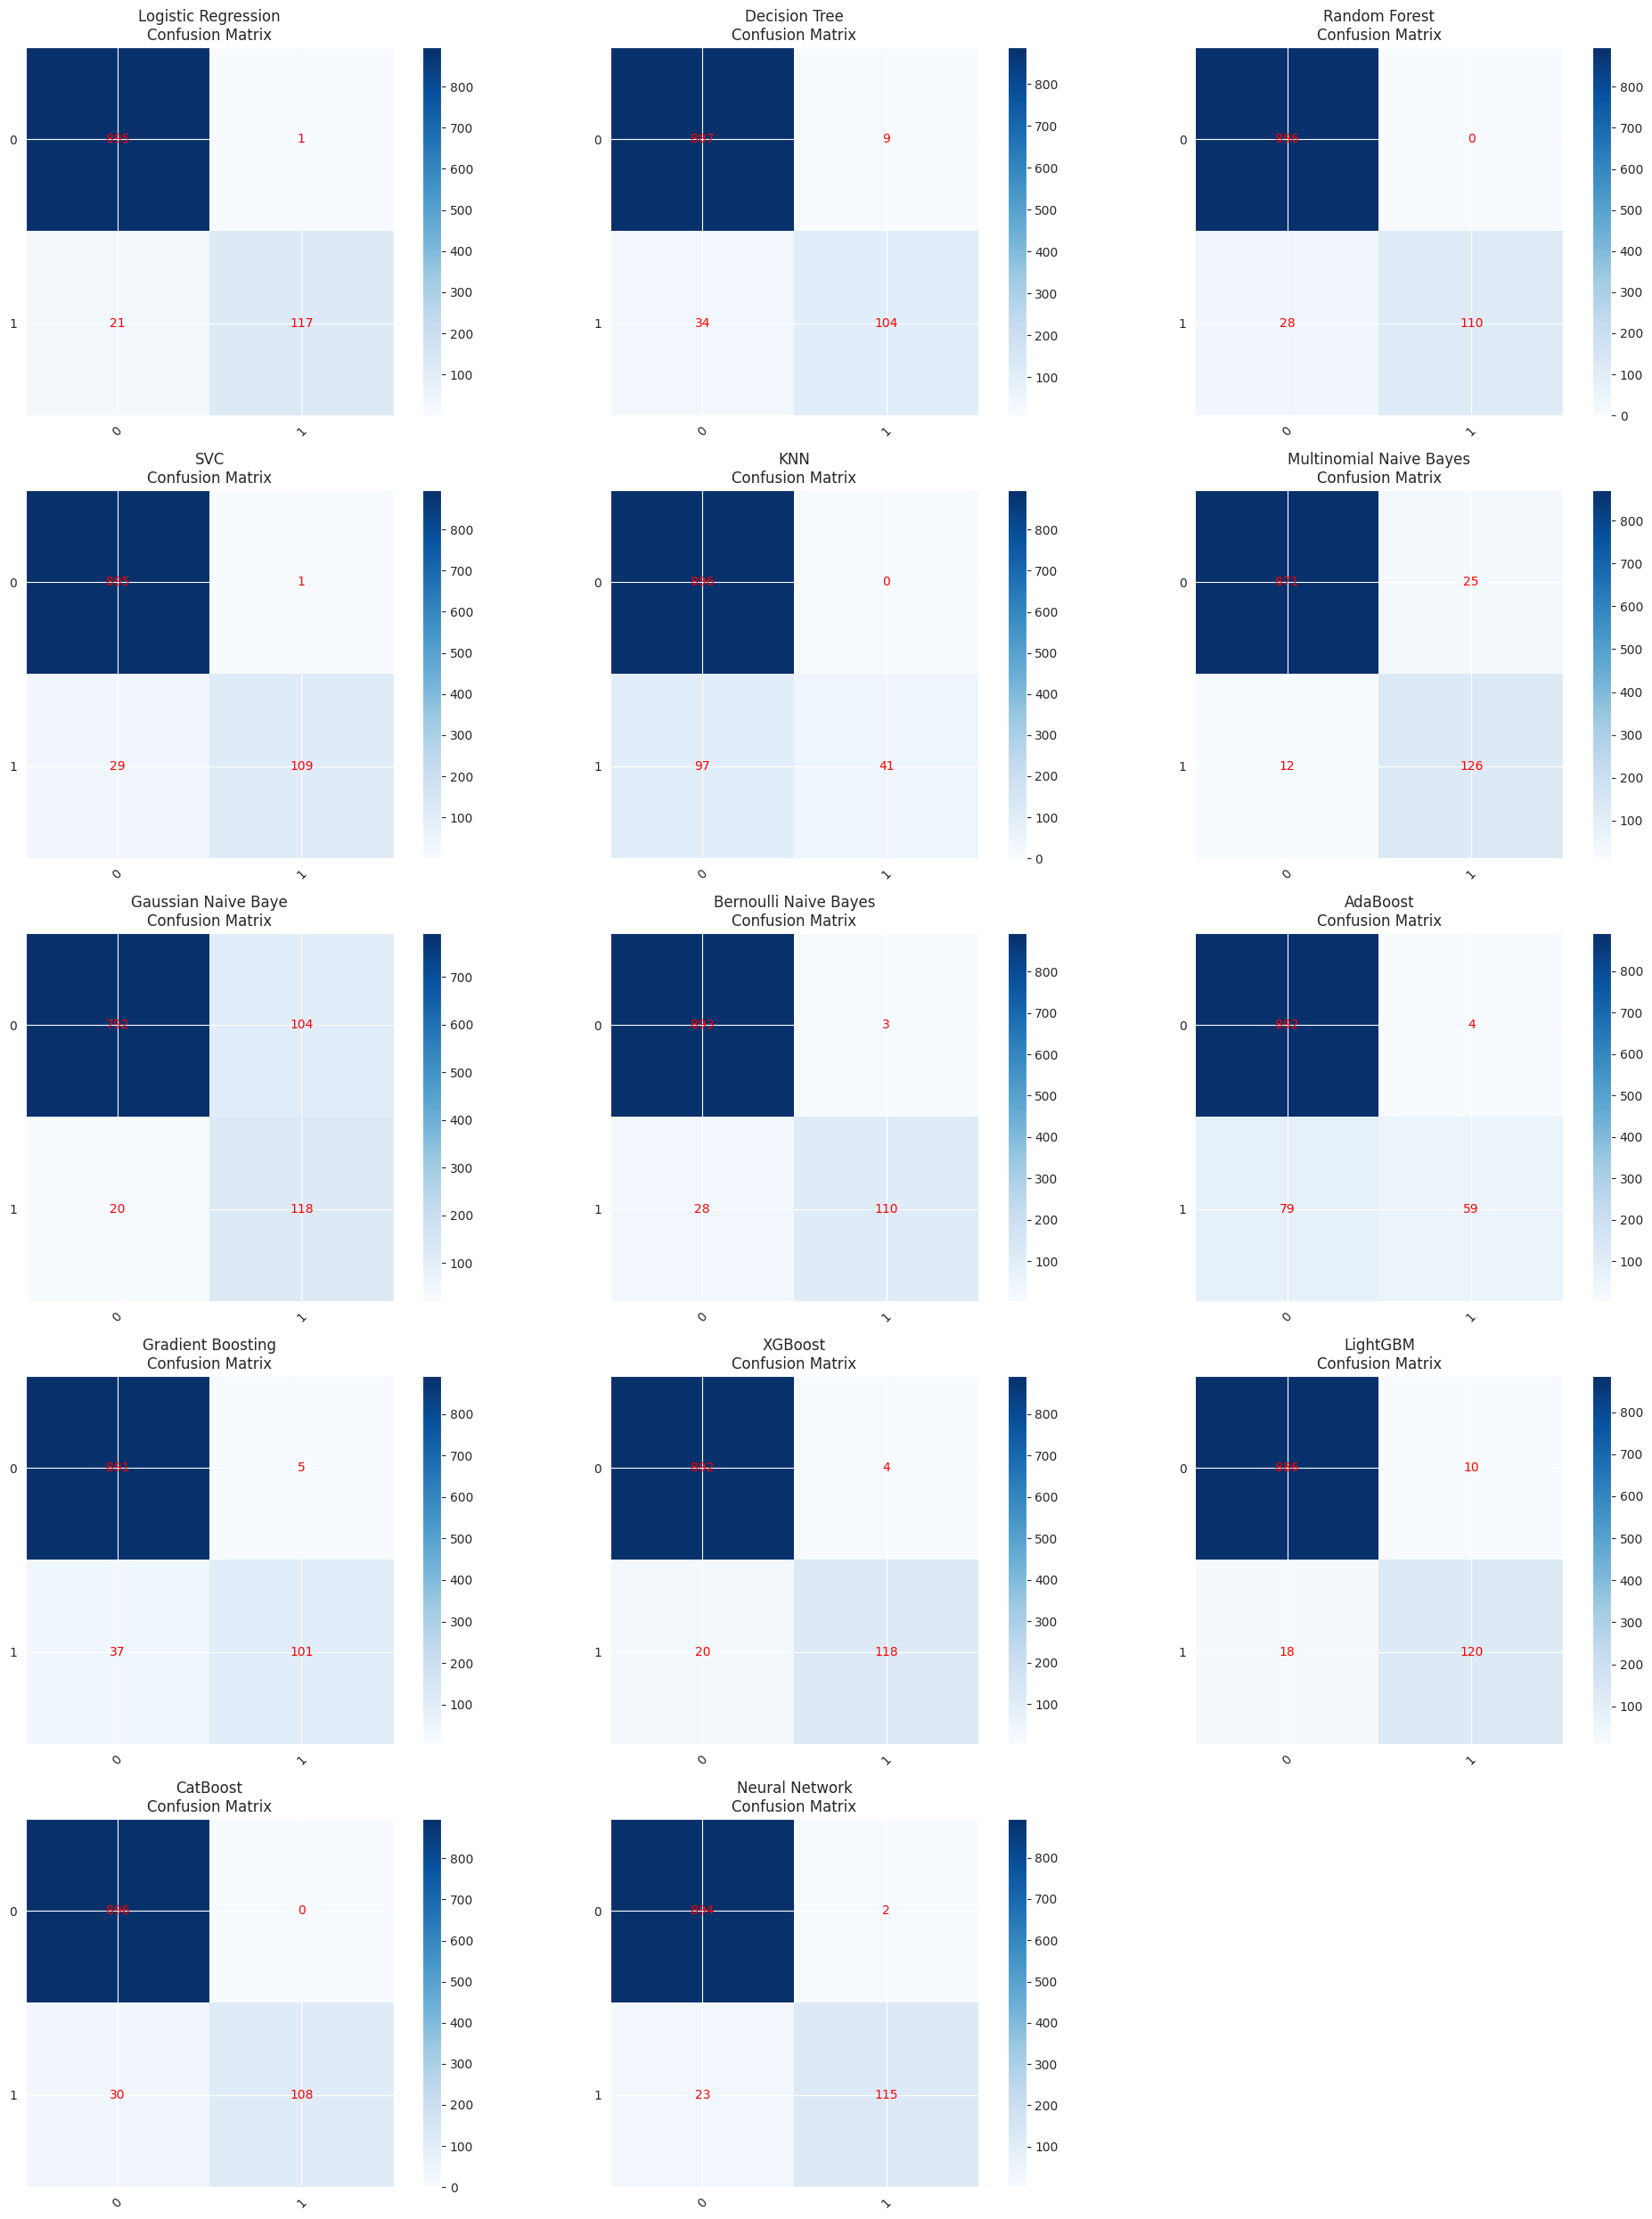

                      Model  Accuracy  Precision    Recall  F1 Score
0       Logistic Regression  0.978723   0.979003  0.978723  0.978010
10                  XGBoost  0.976789   0.976621  0.976789  0.976178
13           Neural Network  0.975822   0.975984  0.975822  0.974967
2             Random Forest  0.972921   0.973741  0.972921  0.971600
11                 LightGBM  0.972921   0.972480  0.972921  0.972577
12                 CatBoost  0.970986   0.971926  0.970986  0.969456
3                       SVC  0.970986   0.971590  0.970986  0.969572
7     Bernoulli Naive Bayes  0.970019   0.970113  0.970019  0.968733
5   Multinomial Naive Bayes  0.964217   0.966127  0.964217  0.964891
9         Gradient Boosting  0.959381   0.959155  0.959381  0.957074
1             Decision Tree  0.958414   0.957381  0.958414  0.956629
8                  AdaBoost  0.919729   0.921025  0.919729  0.906366
6       Gaussian Naive Baye  0.880077   0.916134  0.880077  0.891119
4                       KNN  0.906

In [62]:
performance_cv = evaluate_vectorizer(X_train, X_test, y_train, y_test,algorithms, models_dir ="cv_saved_models")
print(performance_cv)

Training Logistic Regression...
Saved Logistic Regression model to TFidf_saved_models/Logistic Regression.joblib
Logistic Regression Metrics:
Accuracy: 0.9478
Precision: 0.9500
Recall: 0.9478
F1 Score: 0.9425
----------------------------------------
Training Decision Tree...
Saved Decision Tree model to TFidf_saved_models/Decision Tree.joblib
Decision Tree Metrics:
Accuracy: 0.9603
Precision: 0.9605
Recall: 0.9603
F1 Score: 0.9604
----------------------------------------
Training Random Forest...
Saved Random Forest model to TFidf_saved_models/Random Forest.joblib
Random Forest Metrics:
Accuracy: 0.9739
Precision: 0.9744
Recall: 0.9739
F1 Score: 0.9728
----------------------------------------
Training SVC...
Saved SVC model to TFidf_saved_models/SVC.joblib
SVC Metrics:
Accuracy: 0.9662
Precision: 0.9667
Recall: 0.9662
F1 Score: 0.9643
----------------------------------------
Training KNN...
Saved KNN model to TFidf_saved_models/KNN.joblib
KNN Metrics:
Accuracy: 0.9004
Precision: 0.9107

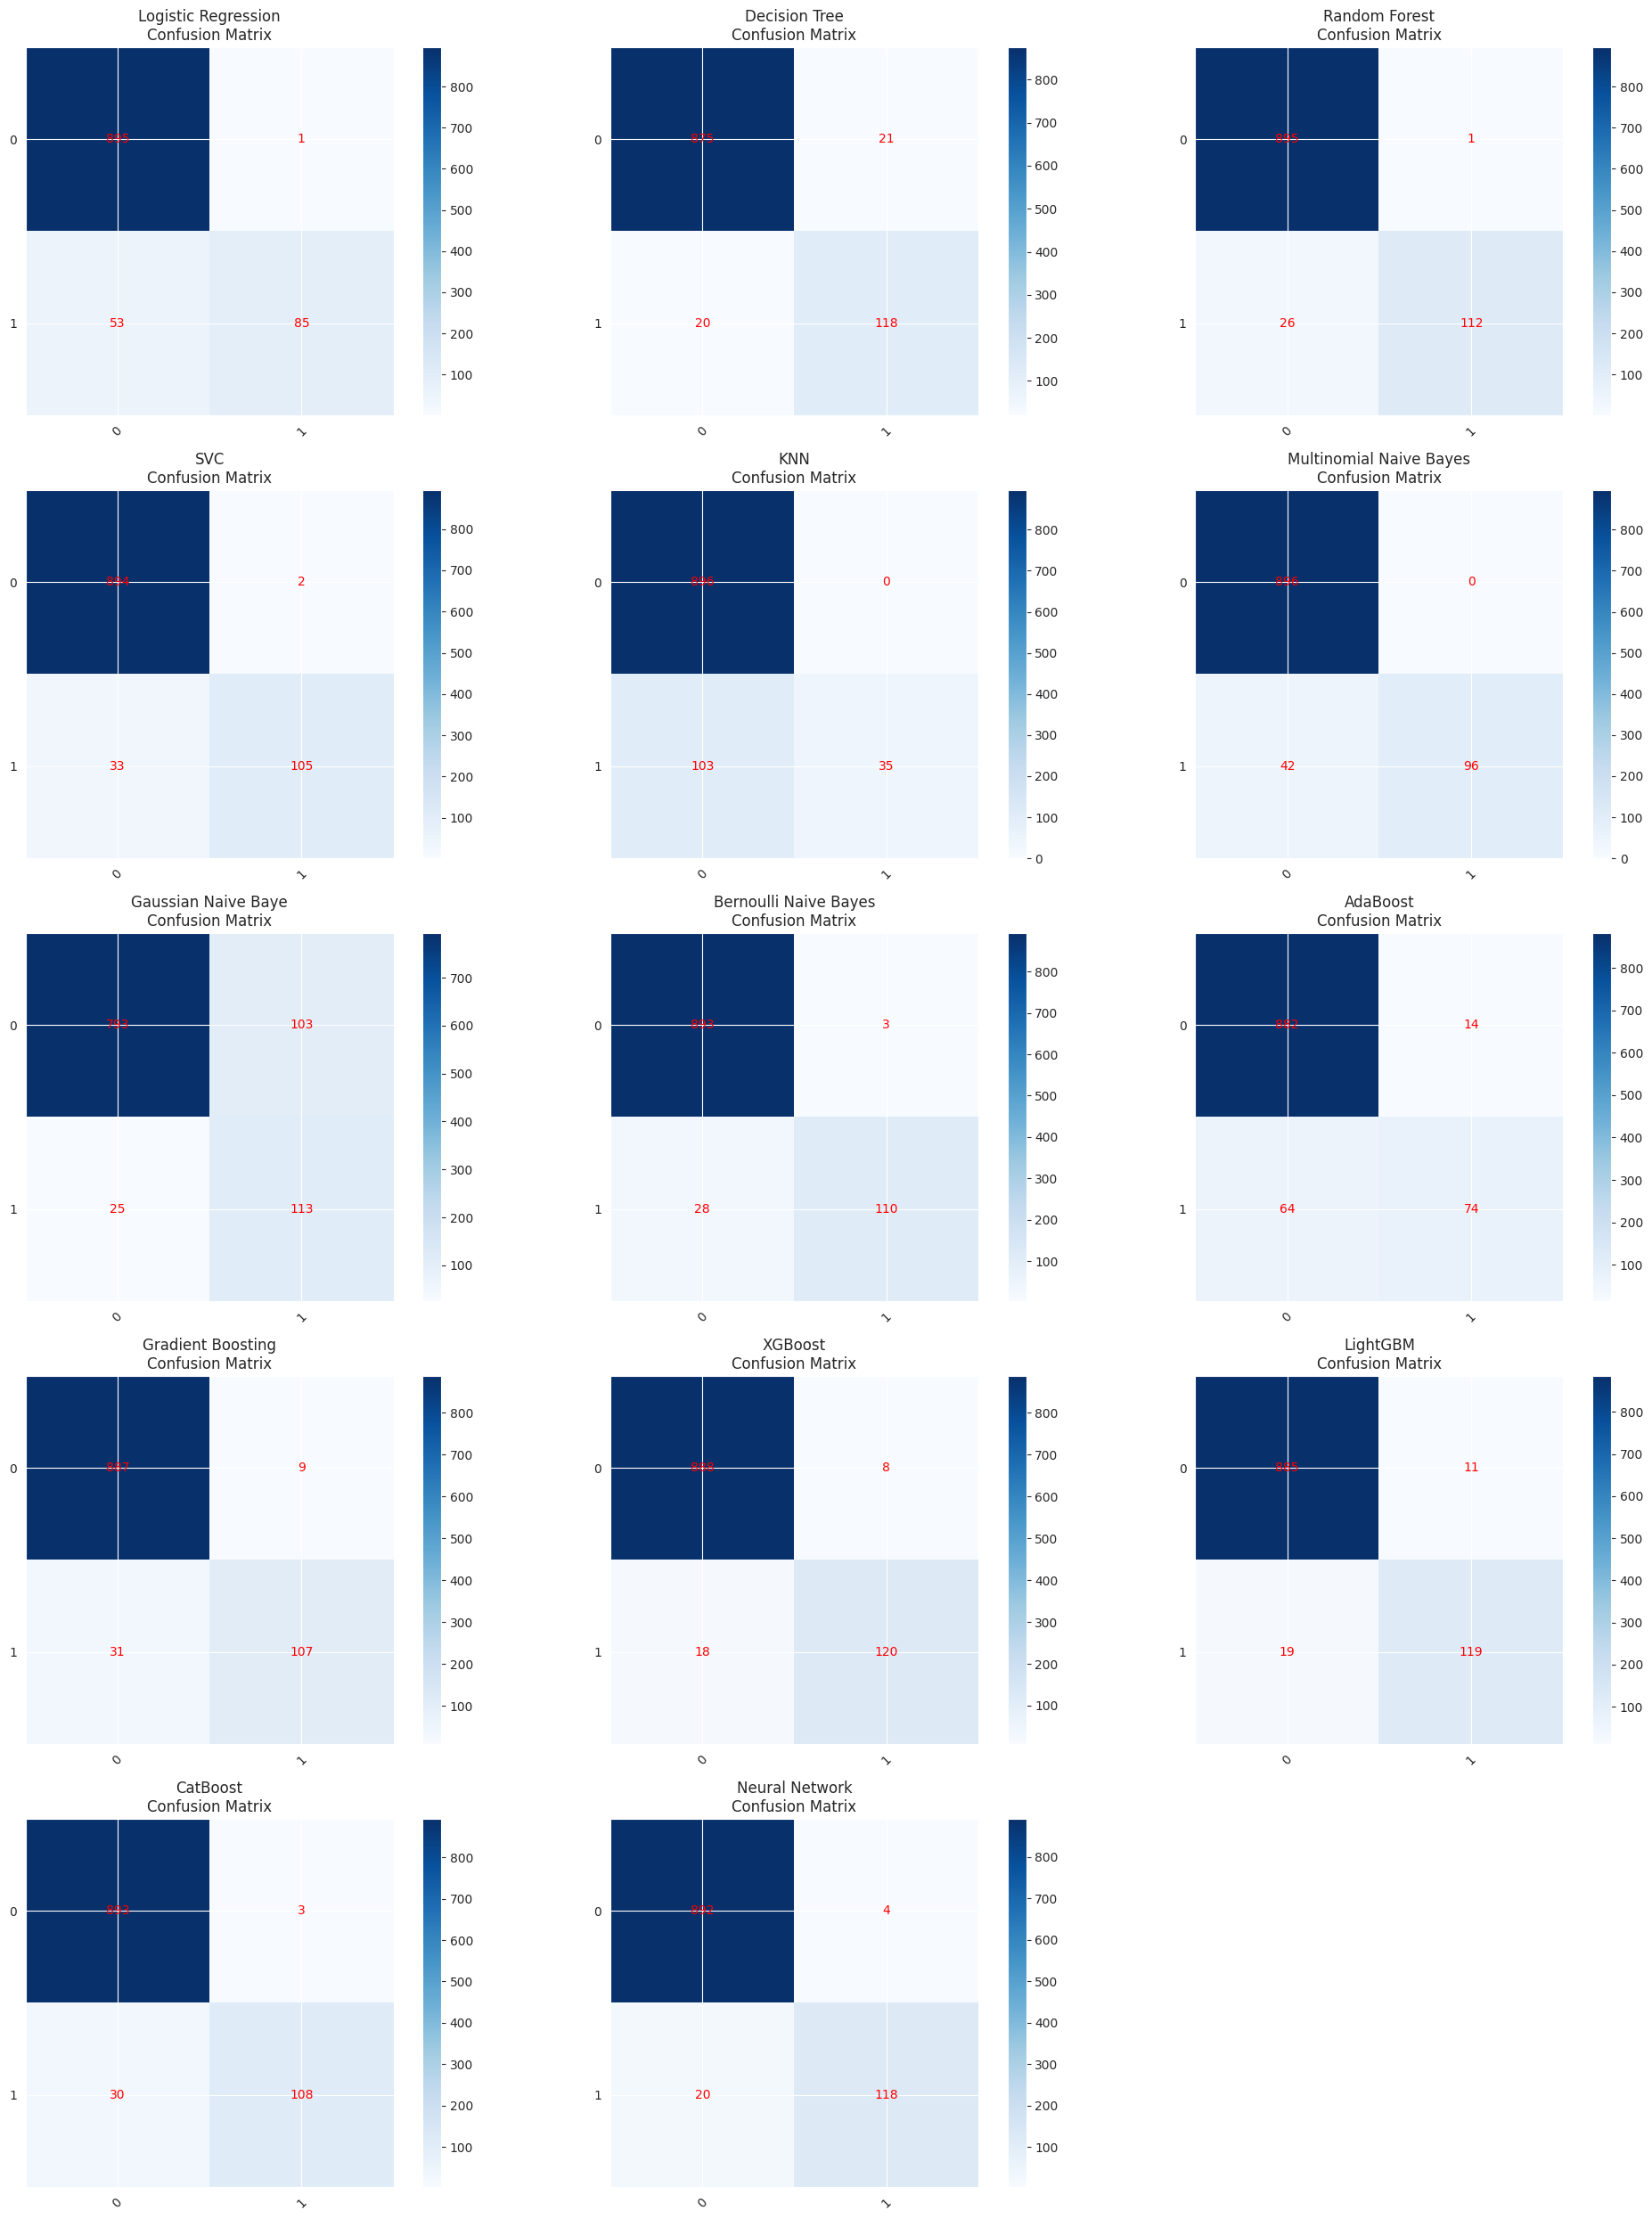

,Model,Accuracy,Precision,Recall,F1 Score
13,Neural Network,0.976789,0.976621,0.976789,0.976178
10,XGBoost,0.974855,0.974443,0.974855,0.974452
2,Random Forest,0.973888,0.974356,0.973888,0.972767
11,LightGBM,0.970986,0.970494,0.970986,0.970618
7,Bernoulli Naive Bayes,0.970019,0.970113,0.970019,0.968733
12,CatBoost,0.968085,0.968228,0.968085,0.966592
3,SVC,0.966151,0.966658,0.966151,0.964297
5,Multinomial Naive Bayes,0.959381,0.961200,0.959381,0.956201
1,Decision Tree,0.960348,0.960473,0.960348,0.960409
9,Gradient Boosting,0.961315,0.960383,0.961315,0.959875


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer() # default

X1 = tfidf.fit_transform(data['transformed_text'], data['num_chars']).toarray()
y1 = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=2)

performance_tfidf = evaluate_vectorizer(X_train, X_test, y_train, y_test,algorithms, models_dir ="TFidf_saved_models")
performance_tfidf

Training Logistic Regression...
Saved Logistic Regression model to tfidf_3000_saved_models/Logistic Regression.joblib
Logistic Regression Metrics:
Accuracy: 0.9565
Precision: 0.9575
Recall: 0.9565
F1 Score: 0.9532
----------------------------------------
Training Decision Tree...
Saved Decision Tree model to tfidf_3000_saved_models/Decision Tree.joblib
Decision Tree Metrics:
Accuracy: 0.9507
Precision: 0.9512
Recall: 0.9507
F1 Score: 0.9509
----------------------------------------
Training Extra Trees...
Saved Extra Trees model to tfidf_3000_saved_models/Extra Trees.joblib
Extra Trees Metrics:
Accuracy: 0.9526
Precision: 0.9510
Recall: 0.9526
F1 Score: 0.9509
----------------------------------------
Training Random Forest...
Saved Random Forest model to tfidf_3000_saved_models/Random Forest.joblib
Random Forest Metrics:
Accuracy: 0.9739
Precision: 0.9741
Recall: 0.9739
F1 Score: 0.9729
----------------------------------------
Training SVC...
Saved SVC model to tfidf_3000_saved_models/S

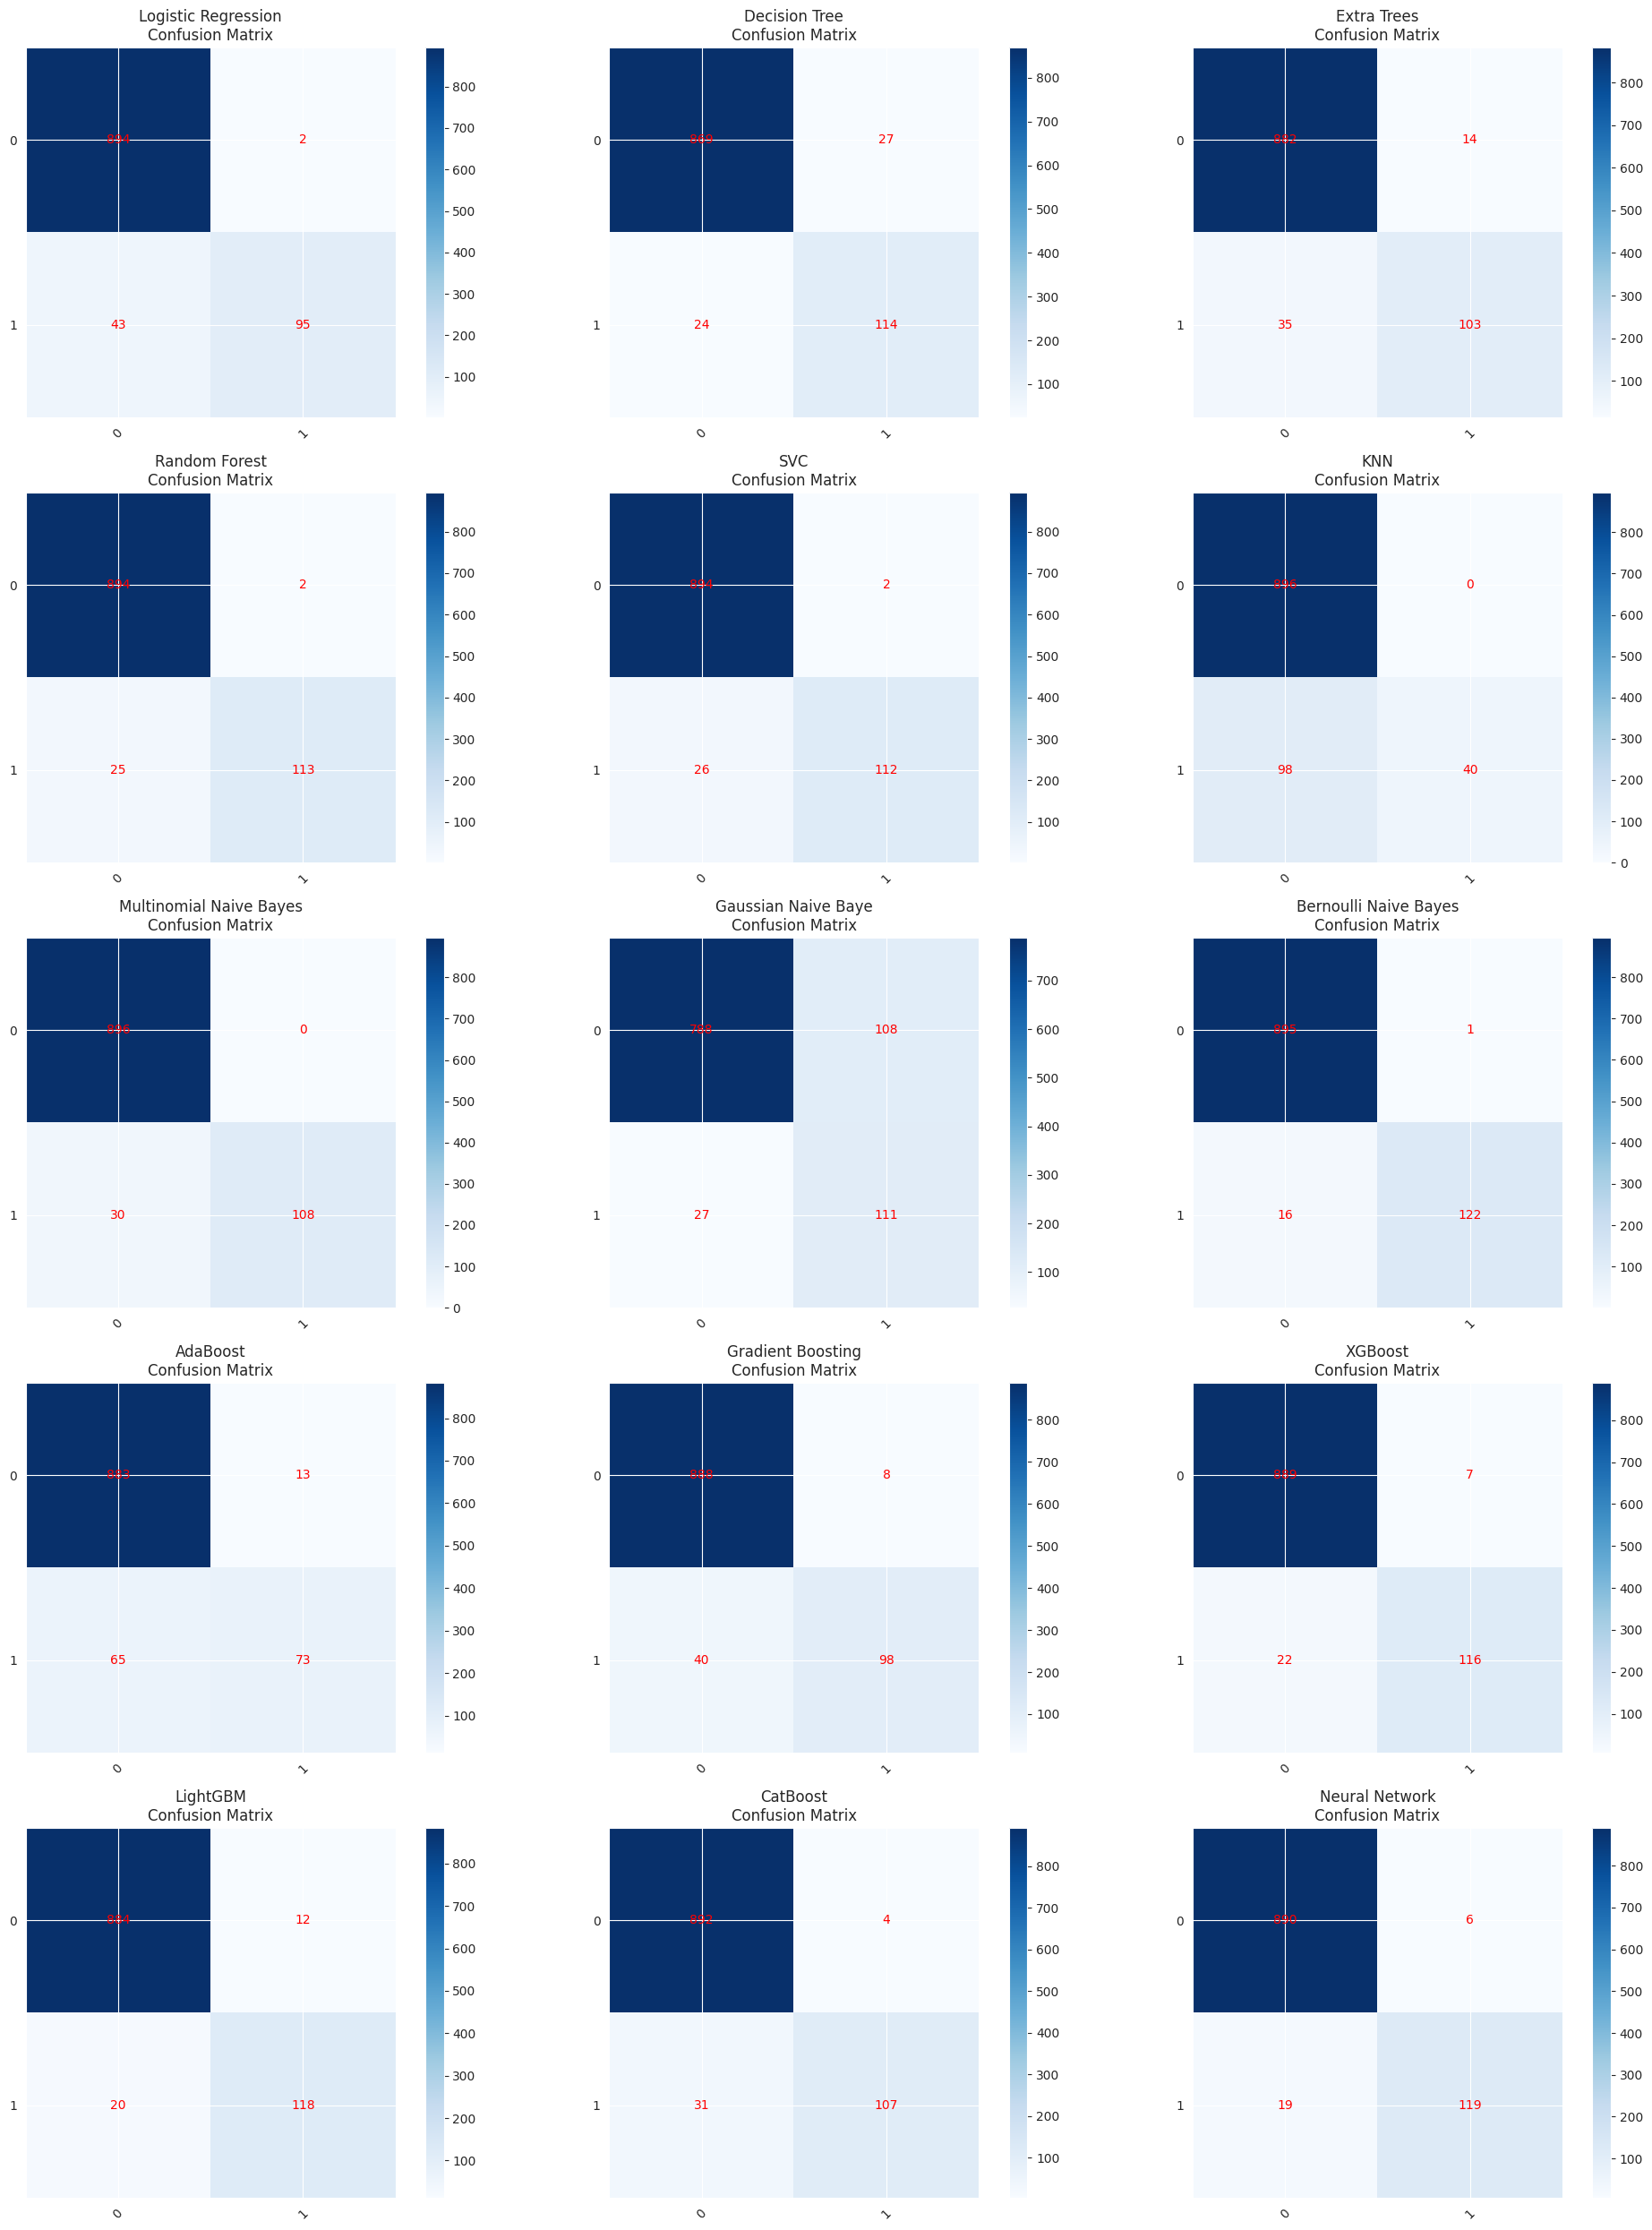

,Model,Accuracy,Precision,Recall,F1 Score
8,Bernoulli Naive Bayes,0.983559,0.983696,0.983559,0.983155
14,Neural Network,0.975822,0.975481,0.975822,0.975312
3,Random Forest,0.973888,0.974106,0.973888,0.972866
4,SVC,0.972921,0.973169,0.972921,0.971810
6,Multinomial Naive Bayes,0.970986,0.971926,0.970986,0.969456
11,XGBoost,0.971954,0.971478,0.971954,0.971264
12,LightGBM,0.969052,0.968509,0.969052,0.968659
13,CatBoost,0.966151,0.966087,0.966151,0.964567
0,Logistic Regression,0.956480,0.957482,0.956480,0.953170
10,Gradient Boosting,0.953578,0.952577,0.953578,0.950942


In [65]:
tfidf1 = TfidfVectorizer(max_features=3000) # max_features = 3000
X2 = tfidf1.fit_transform(data['transformed_text'], data['num_chars']).toarray()
y2 = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=2)

performance_tfidf_3000 = evaluate_vectorizer(X_train, X_test, y_train, y_test,algorithms, models_dir ="tfidf_3000_saved_models")
performance_tfidf_3000

Training Logistic Regression...
Saved Logistic Regression model to scaled_saved_models/Logistic Regression.joblib
Logistic Regression Metrics:
Accuracy: 0.9749
Precision: 0.9750
Recall: 0.9749
F1 Score: 0.9739
----------------------------------------
Training Decision Tree...
Saved Decision Tree model to scaled_saved_models/Decision Tree.joblib
Decision Tree Metrics:
Accuracy: 0.9507
Precision: 0.9512
Recall: 0.9507
F1 Score: 0.9509
----------------------------------------
Training Extra Trees...
Saved Extra Trees model to scaled_saved_models/Extra Trees.joblib
Extra Trees Metrics:
Accuracy: 0.9526
Precision: 0.9510
Recall: 0.9526
F1 Score: 0.9509
----------------------------------------
Training Random Forest...
Saved Random Forest model to scaled_saved_models/Random Forest.joblib
Random Forest Metrics:
Accuracy: 0.9739
Precision: 0.9741
Recall: 0.9739
F1 Score: 0.9729
----------------------------------------
Training SVC...
Saved SVC model to scaled_saved_models/SVC.joblib
SVC Metric

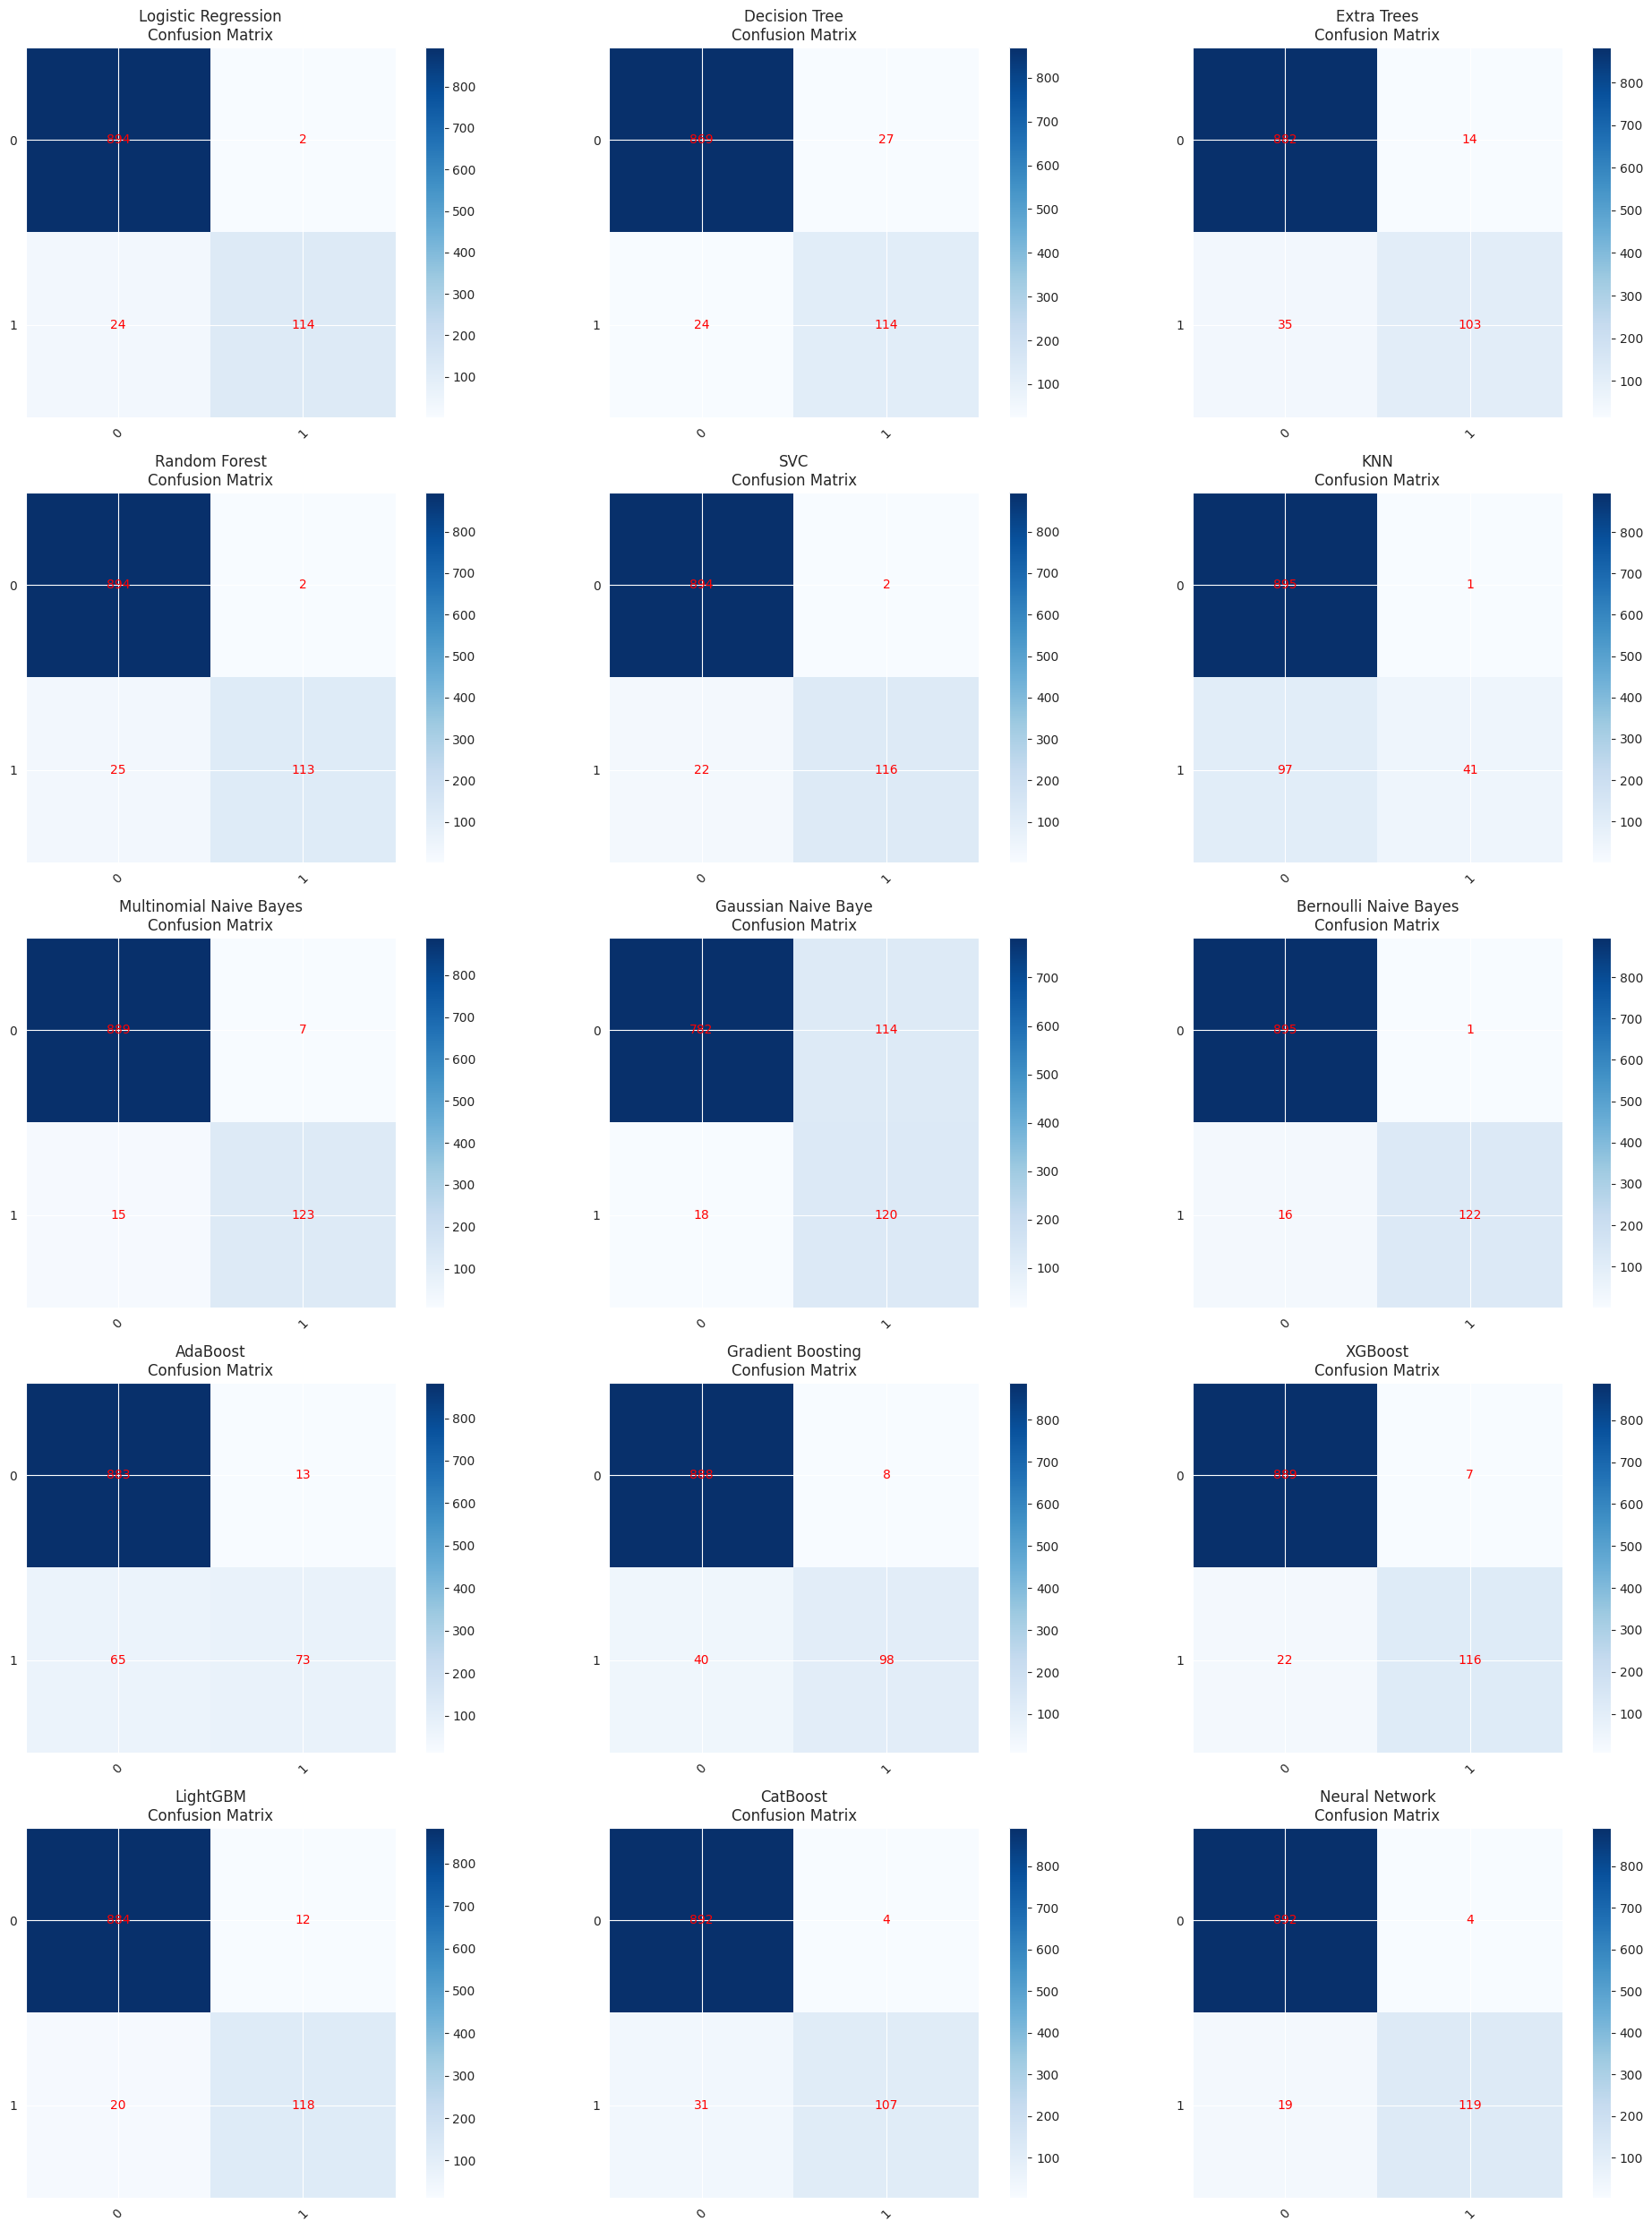

,Model,Accuracy,Precision,Recall,F1 Score
8,Bernoulli Naive Bayes,0.983559,0.983696,0.983559,0.983155
6,Multinomial Naive Bayes,0.978723,0.978435,0.978723,0.978453
14,Neural Network,0.977756,0.977587,0.977756,0.977209
4,SVC,0.976789,0.976926,0.976789,0.976011
0,Logistic Regression,0.974855,0.975044,0.974855,0.973918
3,Random Forest,0.973888,0.974106,0.973888,0.972866
11,XGBoost,0.971954,0.971478,0.971954,0.971264
12,LightGBM,0.969052,0.968509,0.969052,0.968659
13,CatBoost,0.966151,0.966087,0.966151,0.964567
10,Gradient Boosting,0.953578,0.952577,0.953578,0.950942


In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Scaling the data
X3 = tfidf1.fit_transform(data['transformed_text'], data['num_chars']).toarray()
X3 = scaler.fit_transform(X3)
y3 = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=2)

performance_scaled = evaluate_vectorizer(X_train, X_test, y_train, y_test,algorithms, models_dir ="scaled_saved_models")
performance_scaled


In [69]:
performance_temp = pd.merge(
    performance_cv,
    performance_tfidf,
    on='Model',
    how='inner',
    suffixes=('_cv', '_default')
)

performance_temp2 = pd.merge(
    performance_temp,
    performance_tfidf_3000,
    on='Model',
    how='inner'
)

performance = pd.merge(
    performance_temp2,
    performance_scaled,
    on='Model',
    how='inner',
    suffixes=('_3000', '_scaled')
)

performance

,Model,Accuracy_cv,Precision_cv,Recall_cv,F1 Score_cv,Accuracy_default,Precision_default,Recall_default,F1 Score_default,Accuracy_3000,Precision_3000,Recall_3000,F1 Score_3000,Accuracy_scaled,Precision_scaled,Recall_scaled,F1 Score_scaled
0,Logistic Regression,0.978723,0.979003,0.978723,0.978010,0.947776,0.950002,0.947776,0.942450,0.956480,0.957482,0.956480,0.953170,0.974855,0.975044,0.974855,0.973918
1,XGBoost,0.976789,0.976621,0.976789,0.976178,0.974855,0.974443,0.974855,0.974452,0.971954,0.971478,0.971954,0.971264,0.971954,0.971478,0.971954,0.971264
2,Neural Network,0.975822,0.975984,0.975822,0.974967,0.976789,0.976621,0.976789,0.976178,0.975822,0.975481,0.975822,0.975312,0.977756,0.977587,0.977756,0.977209
3,Random Forest,0.972921,0.973741,0.972921,0.971600,0.973888,0.974356,0.973888,0.972767,0.973888,0.974106,0.973888,0.972866,0.973888,0.974106,0.973888,0.972866
4,LightGBM,0.972921,0.972480,0.972921,0.972577,0.970986,0.970494,0.970986,0.970618,0.969052,0.968509,0.969052,0.968659,0.969052,0.968509,0.969052,0.968659
5,CatBoost,0.970986,0.971926,0.970986,0.969456,0.968085,0.968228,0.968085,0.966592,0.966151,0.966087,0.966151,0.964567,0.966151,0.966087,0.966151,0.964567
6,SVC,0.970986,0.971590,0.970986,0.969572,0.966151,0.966658,0.966151,0.964297,0.972921,0.973169,0.972921,0.971810,0.976789,0.976926,0.976789,0.976011
7,Bernoulli Naive Bayes,0.970019,0.970113,0.970019,0.968733,0.970019,0.970113,0.970019,0.968733,0.983559,0.983696,0.983559,0.983155,0.983559,0.983696,0.983559,0.983155
8,Multinomial Naive Bayes,0.964217,0.966127,0.964217,0.964891,0.959381,0.961200,0.959381,0.956201,0.970986,0.971926,0.970986,0.969456,0.978723,0.978435,0.978723,0.978453
9,Gradient Boosting,0.959381,0.959155,0.959381,0.957074,0.961315,0.960383,0.961315,0.959875,0.953578,0.952577,0.953578,0.950942,0.953578,0.952577,0.953578,0.950942


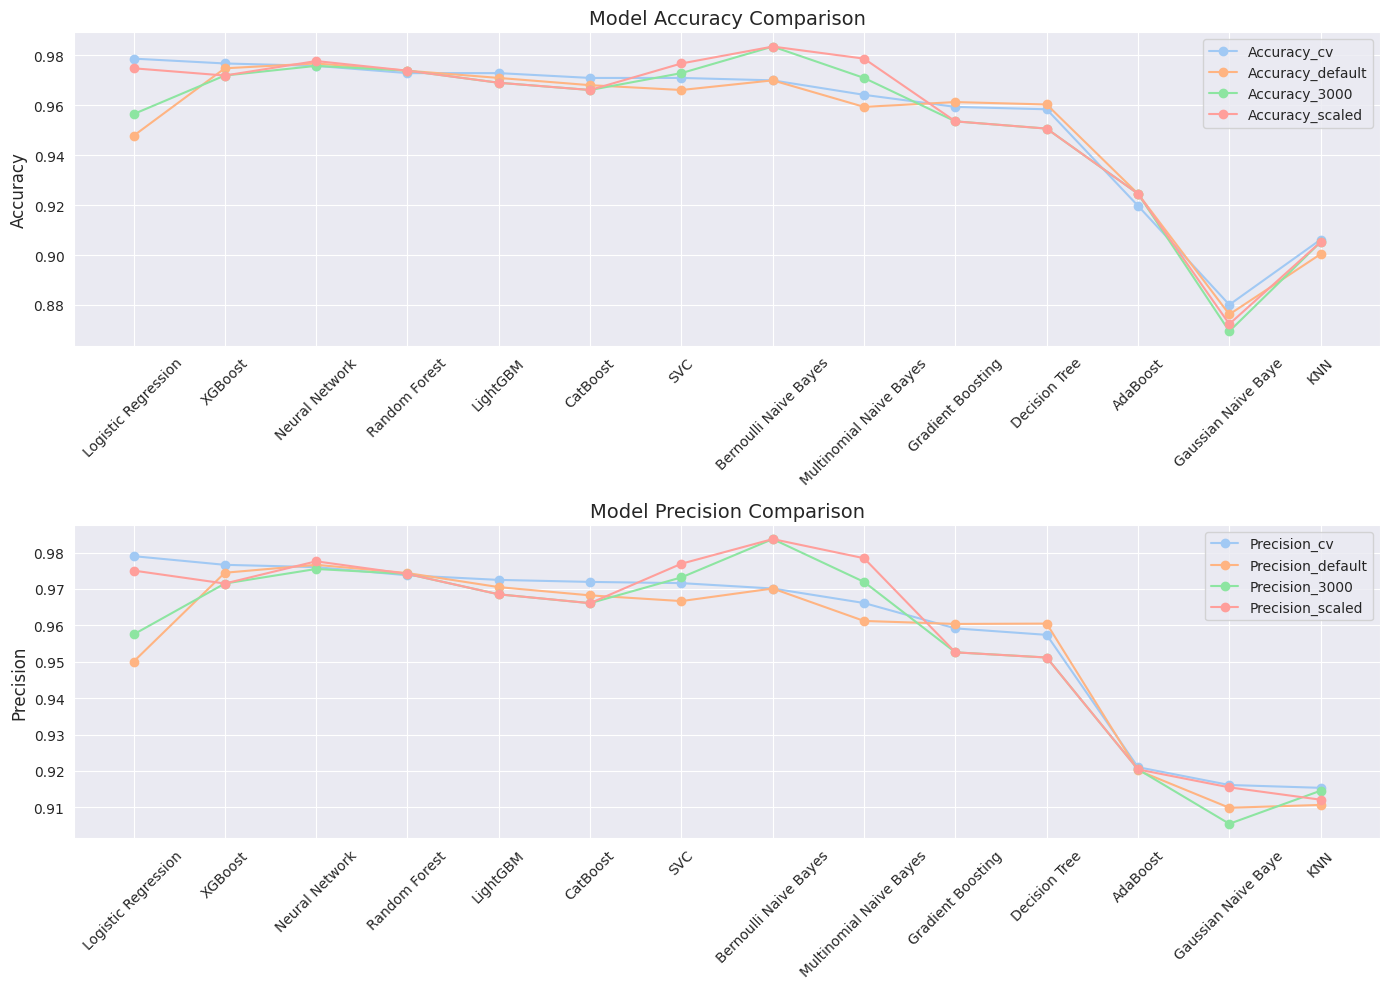

In [70]:
performance_df = pd.DataFrame(performance)

# Plotting performance metrics
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
sns.set_palette('coolwarm')
sns.set_style('darkgrid')

# Accuracy Plot
for col in ["Accuracy_cv", "Accuracy_default", "Accuracy_3000", "Accuracy_scaled"]:
    ax[0].plot(performance_df["Model"], performance_df[col], marker="o", label=col)
ax[0].set_title("Model Accuracy Comparison", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=12)
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

# Precision Plot
for col in ["Precision_cv", "Precision_default", "Precision_3000", "Precision_scaled"]:
    ax[1].plot(performance_df["Model"], performance_df[col], marker="o", label=col)
ax[1].set_title("Model Precision Comparison", fontsize=14)
ax[1].set_ylabel("Precision", fontsize=12)
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [78]:
# prompt: make new predictions on new text

# Assuming 'tfidf1' and 'scaler' are defined from the previous code
# If not, load them:
# tfidf1 = joblib.load("tfidf_3000_saved_models/your_tfidf_model.joblib") # Replace with actual path
# scaler = joblib.load("scaled_saved_models/your_scaler_model.joblib") # Replace with actual path


# Load your best performing model
best_model = joblib.load("scaled_saved_models/Bernoulli Naive Bayes.joblib") # Replace with your best model

ps = nltk.PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

def predict_new_text(new_text, model, tfidf, scaler):
  transformed_text = transform_text(new_text)
  vectorized_text = tfidf.transform([transformed_text]).toarray()
  scaled_text = scaler.transform(vectorized_text)
  prediction = model.predict(scaled_text)
  return prediction[0]

new_texts = [
    "Congratulations! You've won a free prize!",  #Example spam
    "Hey, how's it going? What are you up to today?", #Example ham
]

for text in new_texts:
  prediction = predict_new_text(text, best_model, tfidf1, scaler)
  print(f"Text: {text}")
  print(f"Prediction: {'Spam' if prediction == 1 else 'Ham'}")

Text: Congratulations! You've won a free prize!
Prediction: Ham
Text: Hey, how's it going? What are you up to today?
Prediction: Ham
